******************BUILD PROJECT TIMELINE ANALYSIS****************** 
Analyze project timelines and cost-impacting variables to improve forecasting for new asset deployments in the RAN network. End-2-End Code

**LOADING THE DATA TO THE ENVIRONMENT**
Relative path is used for loading the data for the ease of running the code on different systems.

In [7]:
##################### LOADING ALL THE NECESSARY PACKAGES #####################
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")
directory = "./SiteTracker Projecttracker milestones"
##ADD RELATIVE FILEPATH
main_df = pd.read_csv(os.path.join(directory, os.listdir(directory)[0]))
names = main_df.columns

for filename in os.listdir(directory)[1:]:
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename) 
        df = pd.read_csv(file_path,header = None,names = names)
        main_df = pd.concat([main_df,df], ignore_index=True)

print(main_df.shape)


(783343, 152)


**DATA FILTERATION** The data is filtered based on the internal meetings

**Step-1** Counting the row-wise Null values for each project that is duplicated

**Step-2** Consider the project that has least null values so that all the necessary data is gained 

**Step-3** Applying necessary filterations like Milestone_Achieved = MS13 to get all the Milestone dates, Project_Scope = In-Scope              and Tech_TTO_A not equal to absurd dates

**Step-4** Drop all the unnecessary columns based on the meeting

In [8]:
dupdf = main_df

dupdf['UPDATED_DATE'] = pd.to_datetime(dupdf['UPDATED_DATE'],format='mixed',dayfirst = True)
df_sorted = dupdf.sort_values(by=['Project_ID', 'UPDATED_DATE'], ascending=[True, False])

# Creating a new column to count non-null values across all columns
df_sorted['non_null_count'] = df_sorted.notnull().sum(axis=1)

# Sort by ProjectID and then by non_null_count to prioritize rows with the most filled data
df_sorted = df_sorted.sort_values(by=['Project_ID', 'non_null_count'], ascending=[True, False])

# Drop duplicates based on ProjectID, keeping the row with the most non-null values
df_cleaned = df_sorted.drop_duplicates(subset=['Project_ID'], keep='first')

# Drop the helper column used for counting non-null values
df_cleaned = df_cleaned[(df_cleaned['Milestone_Achieved'] == 'MS13') & (df_cleaned['Project_Scope'] == 'In Scope') & (df_cleaned['Tech_TTO_A'] != '1900-01-01')]

# Dropping all the columns that were discussed in the meeting
drop_columns = ['non_null_count','UPDATED_DATE','Created_Date','Upgrade_Project','Parent_Project','Milestone_Achieved','BT_Project','Project_Scope','Out_of_Scope_Reason','Out_of_Scope_Comments','Date_Removed_from_Scope','TM_Cell_ID_dup','SRN_Upgrade_Type','Created_Date','NTQ','Quality_Assurance','Upgrade_Project_Name']
df_cleaned = df_cleaned.drop(columns=drop_columns)

# Drop all the empty columns
df_cleaned = df_cleaned.dropna(axis=1, how='all')
df_cleaned = df_cleaned.reset_index(drop=True)

cleaned_data = df_cleaned.copy()

cleaned_data.replace('01/01/1900', np.nan, inplace=True)
cleaned_data.replace('01/01/2999', np.nan, inplace=True)
cleaned_data.replace('2999-01-01', np.nan, inplace=True)
cleaned_data.replace('2999-12-31', np.nan, inplace=True)

cols_A = [col for col in cleaned_data.columns if col.endswith('_A')]
cols_F = [col for col in cleaned_data.columns if col.endswith('_F')]
common_cols = set([col[:-2] for col in cols_A]).intersection([col[:-2] for col in cols_F])
selected_columns = [col for col in cleaned_data.columns if col[:-2] in common_cols and (col.endswith('_A') or col.endswith('_F'))]

for col in selected_columns:
     cleaned_data[col] = pd.to_datetime(cleaned_data[col],format = 'mixed', dayfirst = True)


**NULL DATA ANALYSIS** This method takes a dataframe as input and returns the percentage of null values in each column so that the column with more null values can be further investigated and remove if necessary

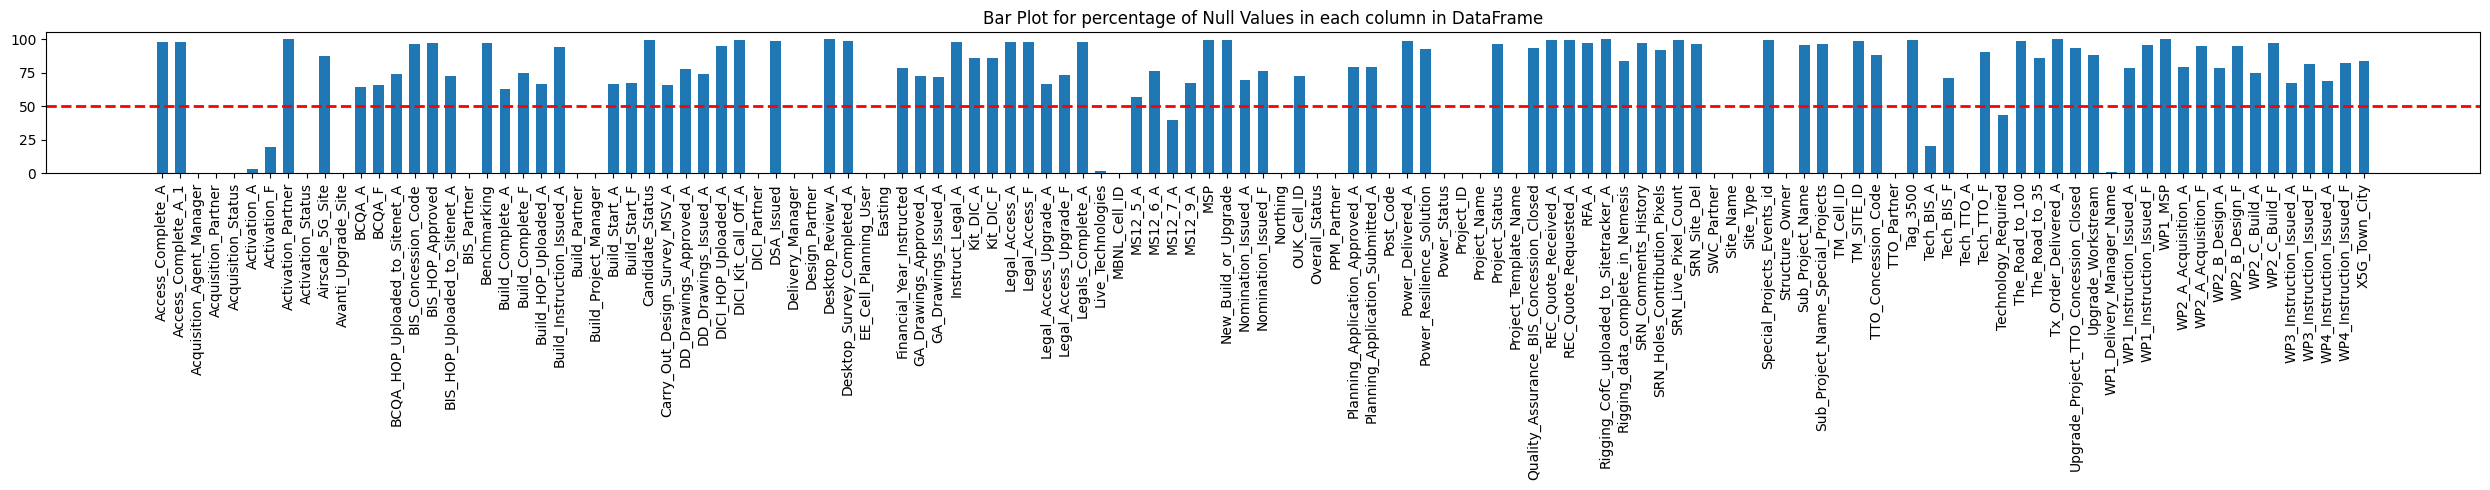

In [9]:
# NULL DATA ANALYSIS
def get_null_data(df):
  null_data = {
      'Column': [],
      'Total Values': [],
      'Null Values': [],
      'Percentage of Null Values': []
  }

  for column in df.columns:
      total_values = len(df[column])  # Total length of the column
      null_values = df[column].isnull().sum()  # Number of null values in the column
      percentage_null = (null_values / total_values) * 100  # Percentage of null values

      # Append results to the data dictionary
      null_data['Column'].append(column)
      null_data['Total Values'].append(total_values)
      null_data['Null Values'].append(null_values)
      null_data['Percentage of Null Values'].append(percentage_null)

  # Create DataFrame from the collected data
  null_df = pd.DataFrame(null_data)

  return null_df
null_df = get_null_data(cleaned_data)
null_df = null_df.sort_values(by='Column')
plt.figure(figsize=(25, 5))
plt.bar(null_df['Column'],null_df['Percentage of Null Values'], width = 0.6)
plt.title('Bar Plot for percentage of Null Values in each column in DataFrame')
plt.xticks(rotation=90)
plt.axhline(y=50, color='red', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()


**FEATURE SELECTION** XGBoost is used for feature selection process. 

All the "Selected columns" from the previous step including categorical variables are given as input for this model and the target column is Tech_TTO_A.

The below code shows top10 important features. Change "topN" to see top n features.

Top features based on importance:
                     Feature  Importance
33         Activation_Status    0.772935
13              Activation_A    0.133094
15                Tech_BIS_A    0.037582
12              Activation_F    0.010662
35              DICI_Partner    0.010472
31               PPM_Partner    0.005227
32               BIS_Partner    0.004443
34       Technology_Required    0.004099
36       Acquisition_Partner    0.002613
30  WP4_Instruction_Issued_F    0.002364


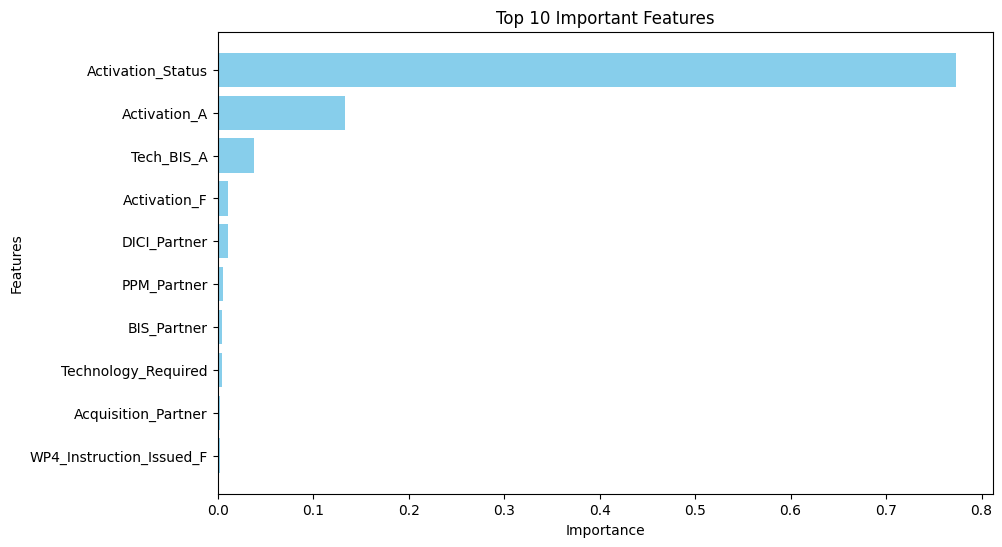

MAE Score with top features: 2193342.3200
R2 Score with top features: 0.8537


In [10]:
### Feature Selection with XG Boost
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

df_fs = cleaned_data.copy()
df_fs = df_fs[selected_columns + ['PPM_Partner','BIS_Partner','Activation_Status','Technology_Required','DICI_Partner','Acquisition_Partner','Build_Partner']]
for col in selected_columns:
    df_fs[col] = pd.to_datetime(df_fs[col])
    df_fs[col] = df_fs[col].astype('int64') // 10**9
categorical_columns = df_fs.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_columns:
  df_fs[col] = label_encoder.fit_transform(df_fs[col].astype(str))

df_fs = df_fs.fillna(df_fs.median())
#df_cleaned.dtypes

X = df_fs.drop(columns=['Tech_TTO_A']) 
y = df_fs['Tech_TTO_A']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

importance = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
topN = 10

print("Top features based on importance:")
print(feature_importance_df.head(topN))  # Display the top N features


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(topN), feature_importance_df['Importance'].head(topN), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top {a} Important Features'.format(a=topN))
plt.gca().invert_yaxis()
plt.show()

top_features = feature_importance_df['Feature'].head(topN) 

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

xgb_model.fit(X_train_top, y_train)

y_pred = xgb_model.predict(X_test_top)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE Score with top features: {mae:.4f}")
print(f"R2 Score with top features: {r2:.4f}")

**Correlation Matrix** The below code shows correlation matrix where all the milestone columns are fed.

From the heatmap, we can select the collinear columns and remove them based on further investigation and analysis. 

Nomination_Issued_F       Nomination_Issued_A         0.831080
Nomination_Issued_A       Legal_Access_Upgrade_A      0.877028
                          Build_Start_A               0.865084
                          BCQA_F                      0.801441
                          BCQA_A                      0.855407
                          Build_Complete_A            0.845394
                          WP2_C_Build_A               0.812362
Legal_Access_F            Legal_Access_A              0.881715
Legal_Access_Upgrade_F    Legal_Access_Upgrade_A      0.851506
Legal_Access_Upgrade_A    Build_Start_F               0.806111
                          Build_Start_A               0.844338
                          BCQA_F                      0.819077
                          BCQA_A                      0.844709
                          Build_Complete_A            0.831378
Build_Start_F             Build_Start_A               0.930506
                          BCQA_F                      0

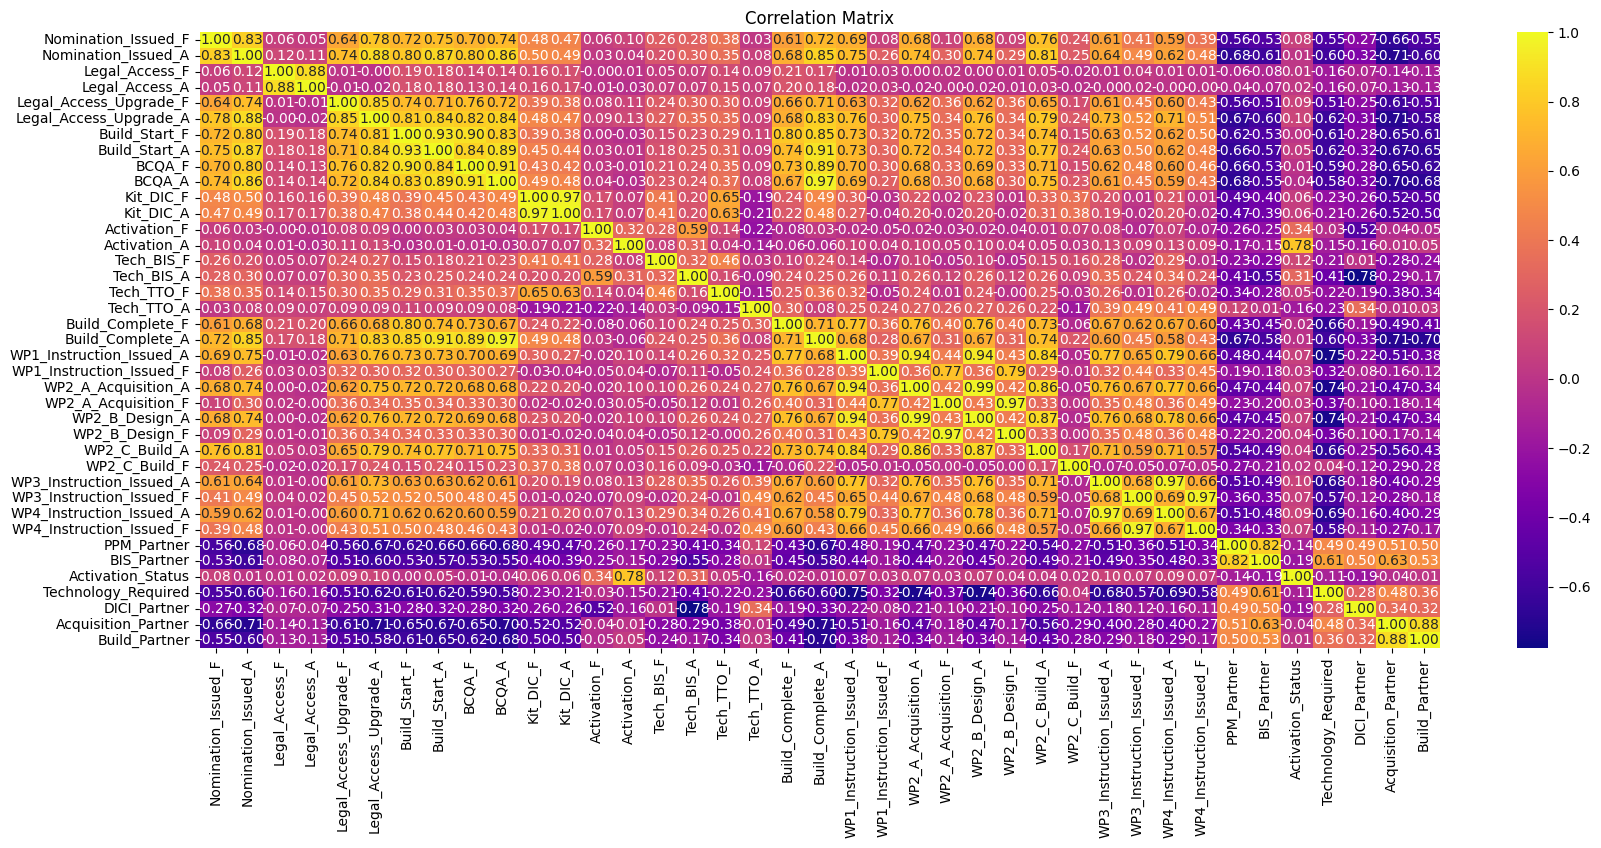

In [11]:
### CORRELATION MATRIX 

cor_matrix = df_fs.corr()

corr_matrix_abs = cor_matrix.abs()

mask = np.triu(np.ones(cor_matrix.shape), k=1)

high_corr = corr_matrix_abs.where(mask == 1)

threshold = 0.8
high_corr_pairs = high_corr.stack().loc[lambda x: x > threshold]

print(high_corr_pairs)

plt.figure(figsize=(20, 8))
sns.heatmap(cor_matrix, annot=True, cmap='plasma', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**TARGET COLUMN ANALYSIS** The target column is selected and the descriptive statistics is analysed to know the variability for handling it efficiently. 

count     3557.000000
mean       329.525162
std       1590.642618
min          0.000000
25%          3.000000
50%          9.000000
75%        252.000000
max      45054.000000
Name: Tech_TTO_Delay, dtype: float64


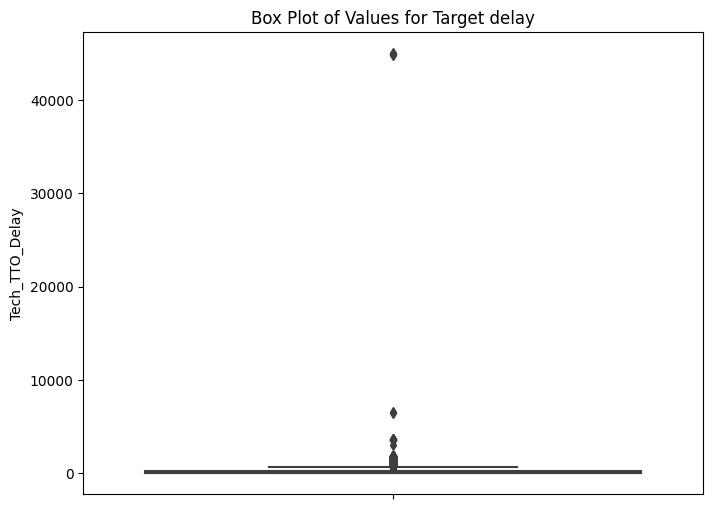

In [13]:
### Target Column Analysis
eda_target = cleaned_data[['Project_ID','Tech_TTO_A','Tech_TTO_F']]
eda_target = eda_target.dropna().reset_index(drop=True)
eda_target['Tech_TTO_Delay'] = (eda_target['Tech_TTO_A'] - eda_target['Tech_TTO_F']).dt.days.abs()
print(eda_target.Tech_TTO_Delay.describe())
plt.figure(figsize=(8, 6))
sns.boxplot(y='Tech_TTO_Delay', data=eda_target)
plt.title('Box Plot of Values for Target delay')
plt.show()

**Outlier Analysis** Here a reference data is used to get the number of days from project completion date from the start date of the project. 

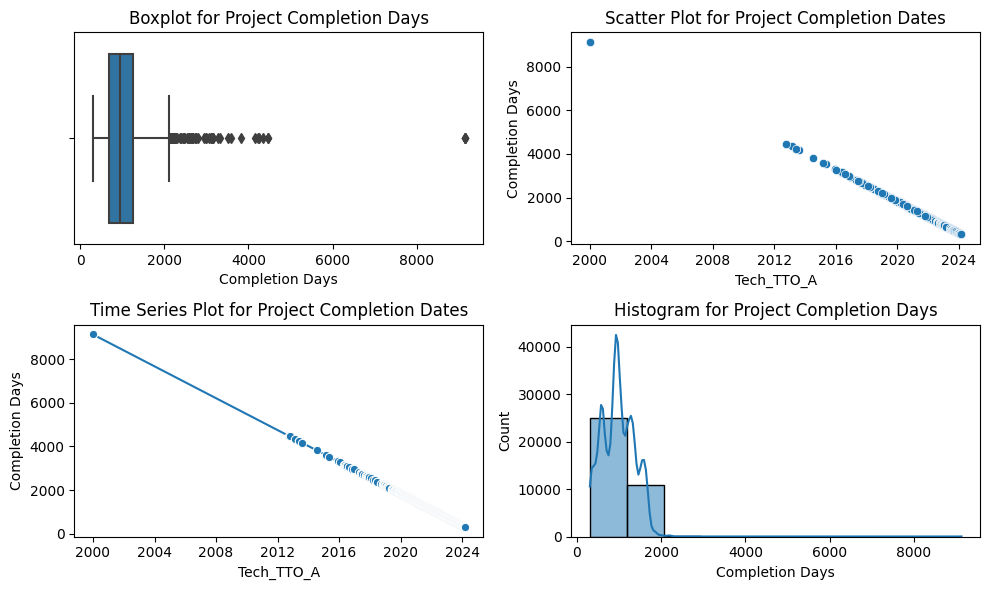

In [16]:
### Outlier Detection Analysis 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ref_date = 'Activation_A'
cleaned_data['Completion Days'] = (cleaned_data['Tech_TTO_A'] - cleaned_data[ref_date]).dt.days.abs()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Plot 1: Boxplot
sns.boxplot(x=cleaned_data['Completion Days'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot for Project Completion Days')

# Plot 2: Scatter plot
sns.scatterplot(x=cleaned_data['Tech_TTO_A'], y=cleaned_data['Completion Days'], ax=axes[0, 1])
axes[0, 1].set_title('Scatter Plot for Project Completion Dates')

# Plot 3: Time series plot
sns.lineplot(x=cleaned_data['Tech_TTO_A'], y=cleaned_data['Completion Days'], marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Time Series Plot for Project Completion Dates')

# Plot 4: Histogram
sns.histplot(cleaned_data['Completion Days'], bins=10, ax=axes[1, 1],kde = True)
axes[1, 1].set_title('Histogram for Project Completion Days')

plt.tight_layout()
plt.show()



**MILESTONE ANALYSIS** All the milestone's actual dates are used for this analysis to know if there are any patters or trend during each milestone's completion.

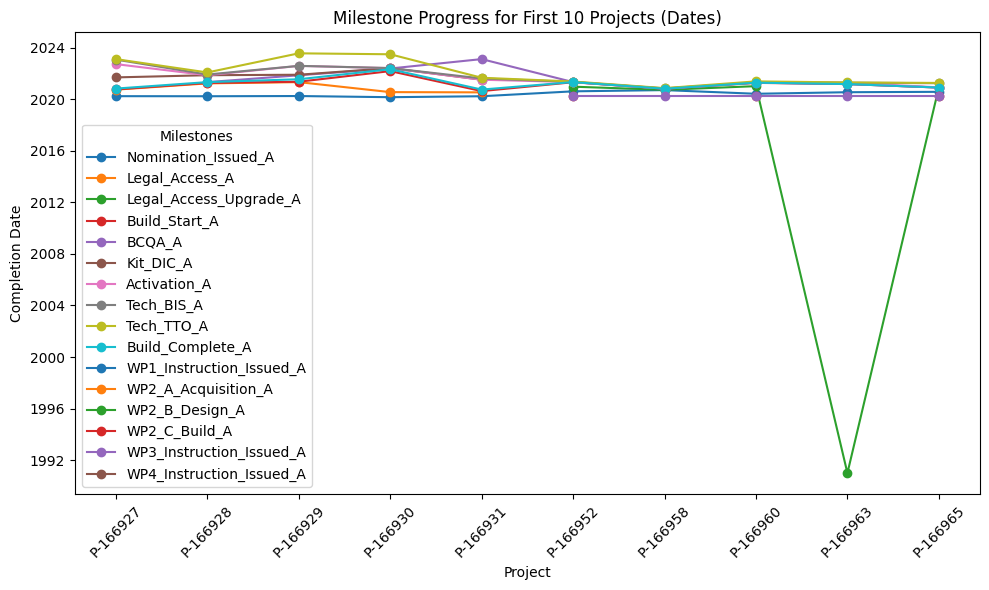

In [17]:
### Milestone Analysis
mile_analysis = [item for item in selected_columns if item.endswith('_A')]
mile_analysis.append('Project_ID')
mile_analysis = cleaned_data[mile_analysis].head(10)
mile_analysis.set_index('Project_ID', inplace=True)
plt.figure(figsize=(10, 6))

# Iterate over each milestone and plot it
for milestone in mile_analysis.columns:
    plt.plot(mile_analysis.index, mile_analysis[milestone], marker='o', label=milestone)

# Add title and labels
plt.title('Milestone Progress for First 10 Projects (Dates)')
plt.xlabel('Project')
plt.ylabel('Completion Date')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Milestones')

# Show the plot
plt.tight_layout()
plt.show()



**NULL HANDLING FUNCTION** The below function handle null values efficiently by using IterativeImputer method.

A clip() function is used for maintaining the uniformity of the data where all the dates lie between a defined range.

In [18]:
def null_imputer(df):
    reference_date = datetime(1970, 1, 1)
    for col in df.columns:
        df[col] = df[col].apply(lambda x: (x - reference_date).days if pd.notna(x) else np.nan)
    
    imputer = IterativeImputer(max_iter=10, random_state=0)
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    min_ordinal = (datetime(2000, 1, 1) - reference_date).days
    max_ordinal = (datetime(2025, 1, 1) - reference_date).days
    
    df = df.clip(lower=min_ordinal, upper=max_ordinal)
    
    # Convert back to datetime after imputation using pd.to_timedelta
    for col in df.columns:
        df[col] = reference_date + pd.to_timedelta(df[col], unit='D')
    return df

****DATA PREPERATION FOR APPROACH 1: MILESTONE BASED DURATION CALCULATION****

Here only the Actual Milestone completion Dates are considered so that they are sorted and subtracted to get the milestone durations.

This approach is considered because the milestones are found to be non-sequential.

In [19]:
### Data for Approach-1: Milestone Based Duration Calculation
milestone_cols = [item for item in selected_columns if item.endswith('_A')] ## To get all the Actual Dates Column names
X_milestones = cleaned_data[milestone_cols] ## Get the data from cleaned Table
X_milestones = null_imputer(X_milestones) ## Null Handling
X_sorted = X_milestones.apply(lambda row: sorted(row), axis=1) ## Sorting the dates row-wise (horizontally) in ascending order
X_diff = X_sorted.apply(lambda row: [(row[i] - row[i-1]).days for i in range(1, len(row))]) ## Subtracting Nth date with (N-1)th Date to get Duration
X_diff = pd.DataFrame(X_diff.tolist(), index=X_milestones.index) ## Resultant Table with 13 differnces
y = (X_milestones['Tech_TTO_A'] - X_milestones.Activation_A).dt.days ### Total duration of the project is the target column
X_train, X_test, y_train, y_test = train_test_split(X_diff, y, test_size=0.15, random_state=42) ## Splitting the data with for training and testing randomly

**Approach-1: Random Forest Regression Model**

Mean Absolute Error in days:  10.325104244229337
R² Score: 0.8100851237775669


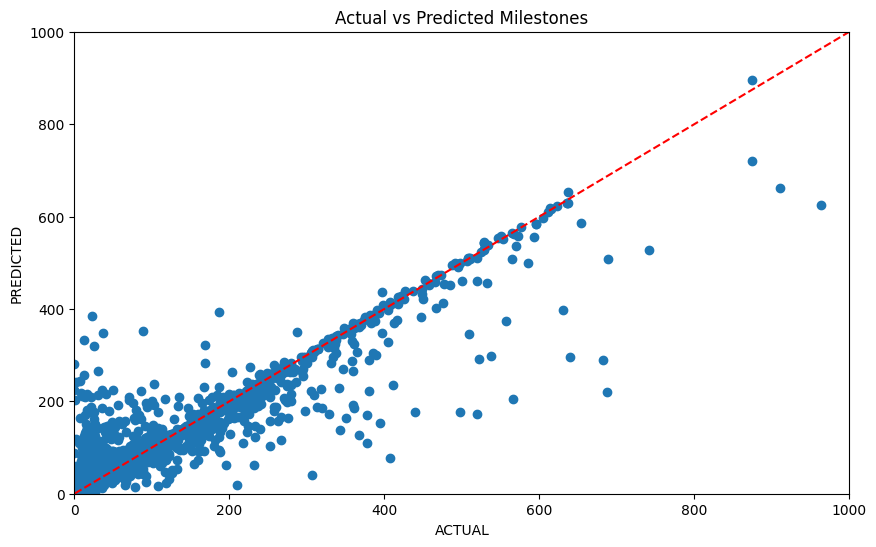

In [20]:
#RANDOM FOREST
milestone_model = RandomForestRegressor(n_estimators = 100, random_state=42)
milestone_model.fit(X_train, y_train)
per_pred = milestone_model.predict(X_train)
y_pred_days = milestone_model.predict(X_test)
mae_days = mean_absolute_error(y_test, y_pred_days)
print("Mean Absolute Error in days: ", mae_days)
r2 = r2_score(y_test, y_pred_days)
print(f'R² Score: {r2}')

plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred_days)
min_val = min(min(y_test), min(y_pred_days))  # Get the minimum value for the diagonal line
max_val = max(max(y_test), max(y_pred_days))  # Get the maximum value for the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
plt.title('Actual vs Predicted Milestones')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

**Approach-1: Linear Regression Model**

Mean Absolute Error in days:  46.89827211400531
R² Score: 0.3254888998673142


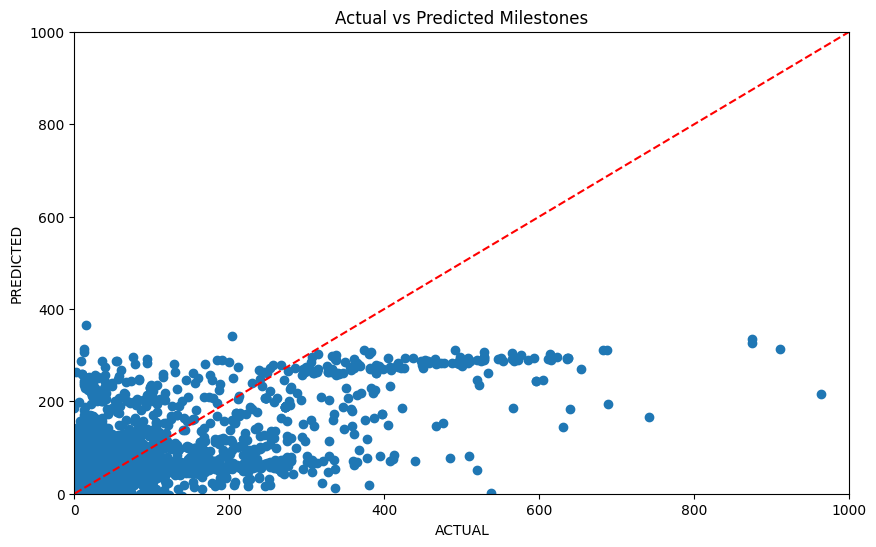

In [21]:
#LINEAR REGRESSION
modellr = LinearRegression()
modellr.fit(X_train, y_train)
y_pred = modellr.predict(X_test)
print("Mean Absolute Error in days: ", mean_absolute_error(y_test, y_pred))
r2lr = r2_score(y_test, y_pred)
print(f'R² Score: {r2lr}')
plt.figure(figsize=(10,6))
plt.scatter(y_test,y_pred)
min_val = min(min(y_test), min(y_pred))  # Get the minimum value for the diagonal line
max_val = max(max(y_test), max(y_pred))  # Get the maximum value for the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
plt.title('Actual vs Predicted Milestones')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

**Approach-1: Long Short-Term Memory Model**

Epoch 1/100
896/896 - 5s - 6ms/step - loss: 0.0111 - val_loss: 7.1259e-04
Epoch 2/100
896/896 - 2s - 3ms/step - loss: 5.9581e-04 - val_loss: 5.0977e-04
Epoch 3/100
896/896 - 2s - 3ms/step - loss: 4.2422e-04 - val_loss: 3.8544e-04
Epoch 4/100
896/896 - 3s - 3ms/step - loss: 3.4144e-04 - val_loss: 3.3753e-04
Epoch 5/100
896/896 - 2s - 3ms/step - loss: 3.0638e-04 - val_loss: 3.1286e-04
Epoch 6/100
896/896 - 2s - 3ms/step - loss: 2.8485e-04 - val_loss: 2.9780e-04
Epoch 7/100
896/896 - 2s - 2ms/step - loss: 2.7186e-04 - val_loss: 2.7785e-04
Epoch 8/100
896/896 - 3s - 3ms/step - loss: 2.6191e-04 - val_loss: 2.8167e-04
Epoch 9/100
896/896 - 2s - 2ms/step - loss: 2.5681e-04 - val_loss: 2.5827e-04
Epoch 10/100
896/896 - 2s - 3ms/step - loss: 2.4700e-04 - val_loss: 2.7553e-04
Epoch 11/100
896/896 - 2s - 3ms/step - loss: 2.3985e-04 - val_loss: 2.5484e-04
Epoch 12/100
896/896 - 2s - 2ms/step - loss: 2.3481e-04 - val_loss: 2.4280e-04
Epoch 13/100
896/896 - 3s - 3ms/step - loss: 2.2934e-04 - val_los

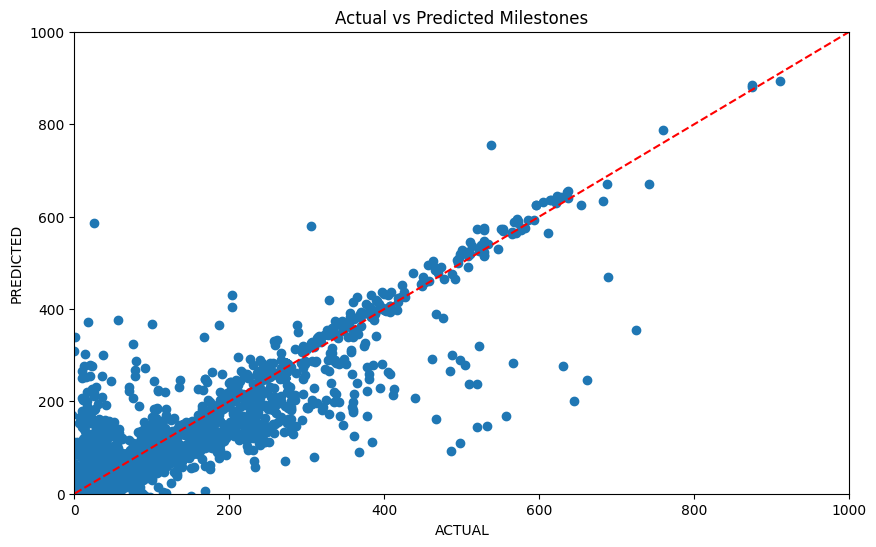

In [22]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = X_diff
scaler = MinMaxScaler()
scaled_data_X = scaler.fit_transform(df)
scaled_data_y = scaler.fit_transform(y.values.reshape(-1, 1))
X_lstm = scaled_data_X.reshape((scaled_data_X.shape[0], 1, scaled_data_X.shape[1]))

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, scaled_data_y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(2))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=2)

predicted_milestone = model.predict(X_test_lstm)
y_pred_original = scaler.inverse_transform(np.concatenate((X_test_lstm[:, 0, :], predicted_milestone), axis=1))[:, -1]
y_test_original = scaler.inverse_transform(np.concatenate((X_test_lstm[:, 0, :], y_test_lstm.reshape(-1, 1)), axis=1))[:, -1]
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')
plt.figure(figsize=(10,6))
plt.scatter(y_test_original,y_pred_original)
min_val = min(min(y_test_original), min(y_pred_original))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_original), max(y_pred_original))  # Get the maximum value for the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
plt.title('Actual vs Predicted Milestones')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.show()

****DATA PREPERATION FOR APPROACH 2: FORECASTED DATE AND DELAY-BASED PREDICTION****

Here both the Actual and Forecasted Milestone completion Dates are considered so that they are subtracted to get the milestone delays.

This approach is considered because the milestones delays play a major role in project completion

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = cleaned_data
df = df.drop(columns = 'Project_ID')
df.replace('2999-01-01', np.nan, inplace=True)
df.replace('01/01/2999', np.nan, inplace=True)
df = df[df['Tech_TTO_A'] >= '31/12/2019']

In [24]:
milestones = ["Activation","BCQA","Build_Complete","Build_Start","Legal_Access","Tech_TTO","Legal_Access_Upgrade","Nomination_Issued","Tech_BIS","WP1_Instruction_Issued","WP2_A_Acquisition","WP2_B_Design","WP2_C_Build","WP3_Instruction_Issued","WP4_Instruction_Issued"]  # Example milestones (non-sequential)
cols = []
for milestone in milestones:
    #Add forecasted dates and delays for each milestone to the feature list
   cols.append(f'{milestone}_A')
   cols.append(f'{milestone}_F')
df = df[cols]## Considering both Actual and Forecatsed columns

In [25]:
df = null_imputer(df) ## Null Handling
milestones = ["Activation","BCQA","Build_Complete","Build_Start","Legal_Access","Legal_Access_Upgrade","Nomination_Issued","Tech_BIS","WP1_Instruction_Issued","WP2_A_Acquisition","WP2_B_Design","WP2_C_Build","WP3_Instruction_Issued","WP4_Instruction_Issued"]  # Example milestones (non-sequential)
for milestone in milestones:
    df[f'{milestone}_D'] = (df[f'{milestone}_A'] - df[f'{milestone}_F']).dt.days ## Actual - Forecast = Delay
    # Prepare features and target
features = []

for milestone in milestones:
    # Add forecasted dates and delays for each milestone to the feature list
    features.append(f'{milestone}_F')
    features.append(f'{milestone}_D')

# Create the feature matrix X
X = df[features]

# Convert forecasted dates to numeric values (timestamps)
for feature in features:
    if '_F' in feature:
        X[feature] = pd.to_datetime(X[feature]).apply(lambda x: x.timestamp())

# The target variable is the actual project end date (e.g., milestone X)
y = pd.to_datetime(df['Tech_TTO_A']).apply(lambda x: x.timestamp())
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**DELAY ANALYSIS** An analysis is done on the delays of each milestone below to check which milestone has more number of delays 

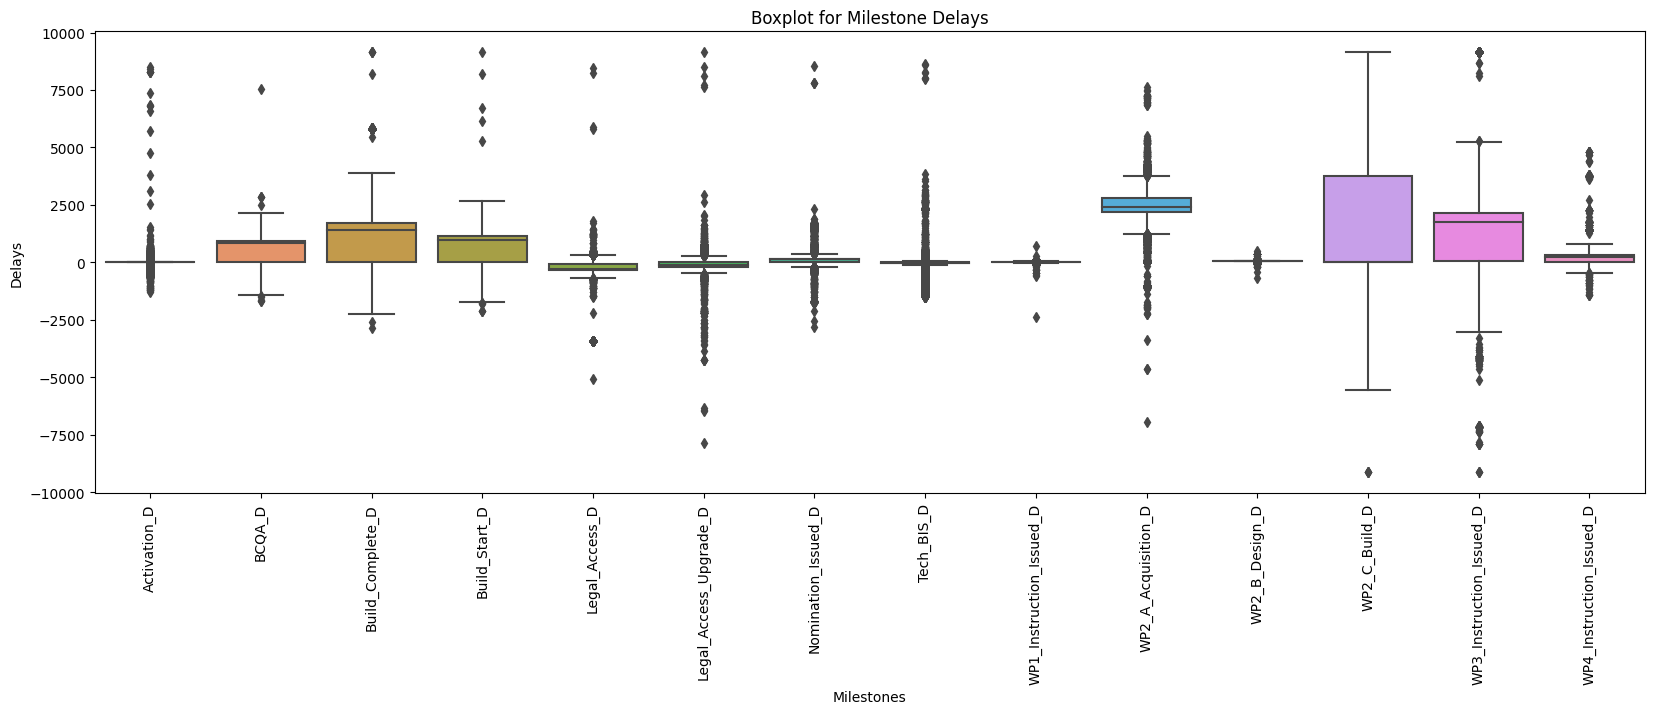

In [26]:
### Delay Analysis
delay_analysis = [item for item in df.columns if item.endswith('_D')]
delay_analysis = df[delay_analysis]
data_melted = delay_analysis.melt(var_name='Milestones', value_name='Delays')
plt.figure(figsize=(20, 6))
sns.boxplot(x='Milestones', y='Delays', data=data_melted)
plt.title('Boxplot for Milestone Delays')
plt.xticks(rotation=90)
plt.show()

**Approach-2: Random Forest Regression Model**

Mean Absolute Error (MAE): 13 days 23:21:32.801799269
R² Score: 0.9847422054347027
Predicted End Dates vs Actual End Dates


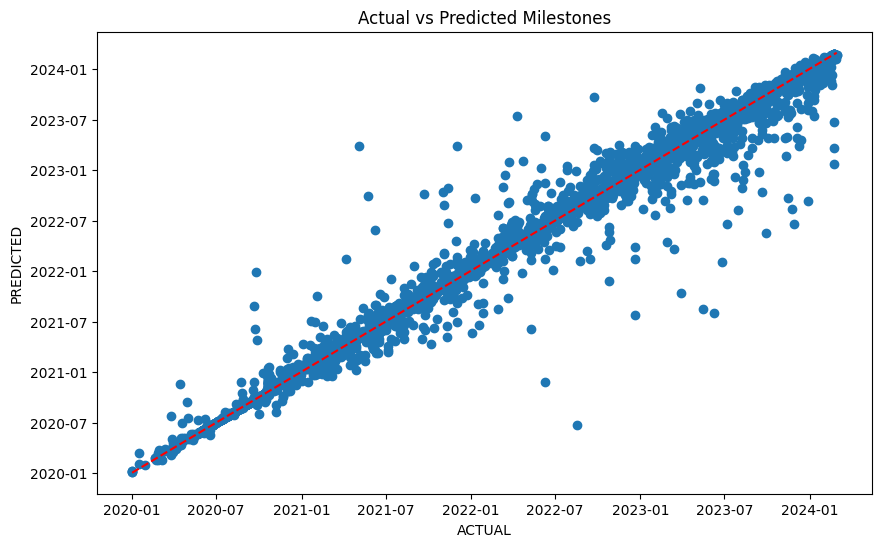

In [27]:
# Initialize the RandomForestRegressor for Approach 2
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Convert predicted and actual timestamps back to dates
y_pred_dates = pd.to_datetime(y_pred, unit='s')  # Convert predicted timestamps to dates
y_test_dates = pd.to_datetime(y_test, unit='s')  # Convert actual timestamps to dates

# Evaluate model performance
mae = np.mean(np.abs(y_test_dates - y_pred_dates))
print(f"Mean Absolute Error (MAE): {mae}")
r21 = r2_score(y_test_dates, y_pred_dates)
print(f'R² Score: {r21}')
# Example: Print predicted vs actual end dates for comparison
print("Predicted End Dates vs Actual End Dates")
#print(pd.DataFrame({'Predicted End Date': y_pred_dates, 'Actual End Date': y_test_dates}))
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(y_test_dates,y_pred_dates)
min_val = min(min(y_test_dates), min(y_pred_dates))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_dates), max(y_pred_dates))  # Get the maximum value for the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
plt.title('Actual vs Predicted Milestones')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')
plt.show()

**Approach-2: Linear Regression Model**

Mean Absolute Error (MAE): 45 days 17:11:37.351539866
R² Score: 0.9469749647781145


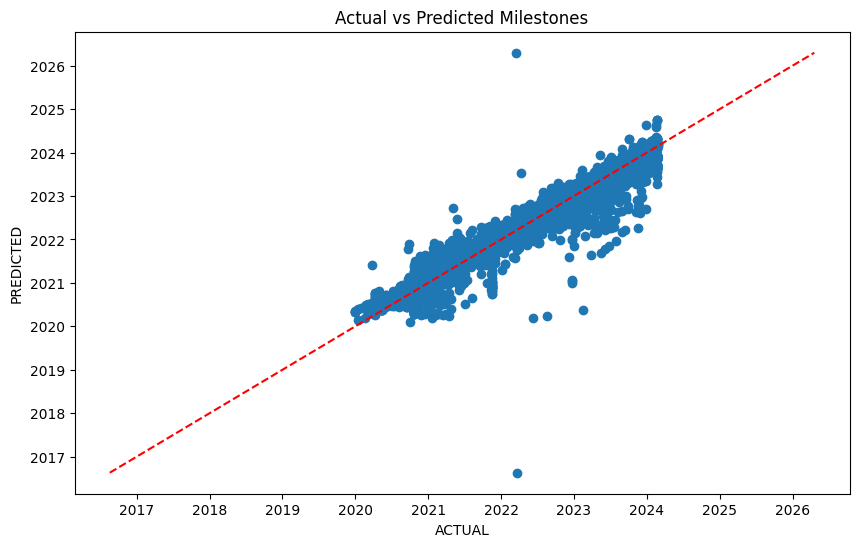

In [28]:
#LINEAR REGRESSION
modellr_a2 = LinearRegression()
modellr_a2.fit(X_train, y_train)
y_pred_a2 = modellr_a2.predict(X_test)

y_pred_dates_a2 = pd.to_datetime(y_pred_a2, unit='s')  # Convert predicted timestamps to dates
y_test_dates_a2 = pd.to_datetime(y_test, unit='s')

mae_a2 = np.mean(np.abs(y_test_dates_a2 - y_pred_dates_a2))
print(f"Mean Absolute Error (MAE): {mae_a2}")
r2lr_a2 = r2_score(y_test_dates_a2, y_pred_dates_a2)
print(f'R² Score: {r2lr_a2}')
plt.figure(figsize=(10,6))
plt.scatter(y_test_dates_a2,y_pred_dates_a2)
min_val = min(min(y_test_dates_a2), min(y_pred_dates_a2))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_dates_a2), max(y_pred_dates_a2))  # Get the maximum value for the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
plt.title('Actual vs Predicted Milestones')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')
plt.show()

**Approach-2: Long Short-Term Memory (LSTM) Model**

Epoch 1/100
890/890 - 4s - 5ms/step - loss: 0.0316 - val_loss: 0.0122
Epoch 2/100
890/890 - 2s - 2ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 3/100
890/890 - 2s - 2ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 4/100
890/890 - 2s - 2ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 5/100
890/890 - 2s - 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/100
890/890 - 2s - 2ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 7/100
890/890 - 2s - 2ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 8/100
890/890 - 3s - 3ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 9/100
890/890 - 2s - 2ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/100
890/890 - 2s - 2ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 11/100
890/890 - 2s - 2ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 12/100
890/890 - 2s - 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 13/100
890/890 - 2s - 2ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 14/100
890/890 - 2s - 2ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 15/100
89

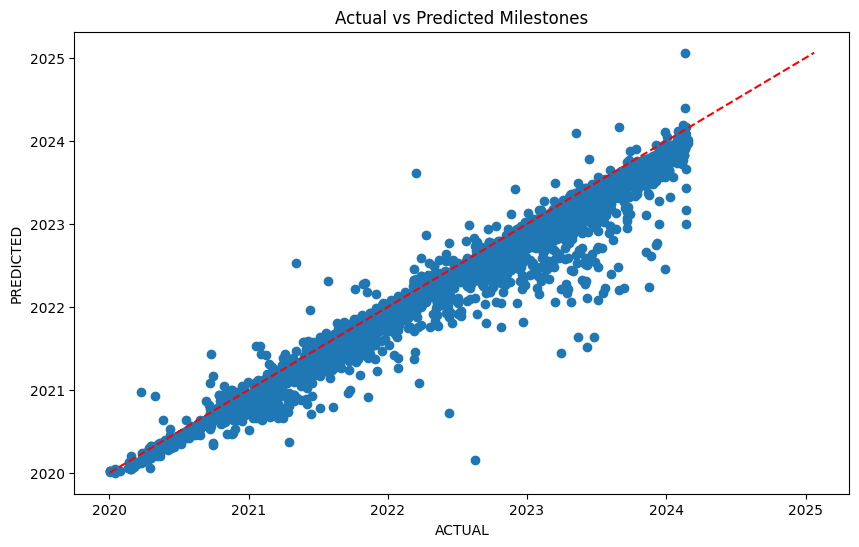

In [29]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df_lstm_a2 = X
y_a2 = y
scaler_a2 = MinMaxScaler()
scaled_data_X_a2 = scaler_a2.fit_transform(df_lstm_a2)
scaled_data_y_a2 = scaler_a2.fit_transform(y_a2.values.reshape(-1, 1))
X_lstm_a2 = scaled_data_X_a2.reshape((scaled_data_X_a2.shape[0], 1, scaled_data_X_a2.shape[1]))

X_train_lstm_a2, X_test_lstm_a2, y_train_lstm_a2, y_test_lstm_a2 = train_test_split(X_lstm_a2, scaled_data_y_a2, test_size=0.2, random_state=42)

model_a2 = Sequential()
model_a2.add(LSTM(50, activation='relu', input_shape=(X_train_lstm_a2.shape[1], X_train_lstm_a2.shape[2])))
model_a2.add(Dense(1))

model_a2.compile(optimizer='adam', loss='mean_squared_error')

model_a2.fit(X_train_lstm_a2, y_train_lstm_a2, epochs=100, batch_size=32, validation_data=(X_test_lstm_a2, y_test_lstm_a2), verbose=2)

predicted_milestone_a2 = model_a2.predict(X_test_lstm_a2)
y_pred_original_a2 = scaler_a2.inverse_transform(np.concatenate((X_test_lstm_a2[:, 0, :], predicted_milestone_a2), axis=1))[:, -1]
y_test_original_a2 = scaler_a2.inverse_transform(np.concatenate((X_test_lstm_a2[:, 0, :], y_test_lstm_a2.reshape(-1, 1)), axis=1))[:, -1]
y_pred_original_a2 = pd.to_datetime(y_pred_original_a2, unit='s')  # Convert predicted timestamps to dates
y_test_original_a2 = pd.to_datetime(y_test_original_a2, unit='s')

mae_a2_lstm = np.abs(y_test_original_a2 - y_pred_original_a2).mean()
print(f"Mean Absolute Error (MAE): {mae_a2_lstm}")
r2lr_a2_lstm = r2_score(y_test_original_a2, y_pred_original_a2)
print(f'R² Score: {r2lr_a2_lstm}')
plt.figure(figsize=(10,6))
plt.scatter(y_test_original_a2,y_pred_original_a2)
min_val = min(min(y_test_original_a2), min(y_pred_original_a2))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_original_a2), max(y_pred_original_a2))  # Get the maximum value for the diagonal line
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
plt.title('Actual vs Predicted Milestones')
plt.xlabel('ACTUAL')
plt.ylabel('PREDICTED')
plt.show()

Mean Absolute Error (MAE): 25 days 14:17:29.663424186
R² Score: 0.9759402140385585


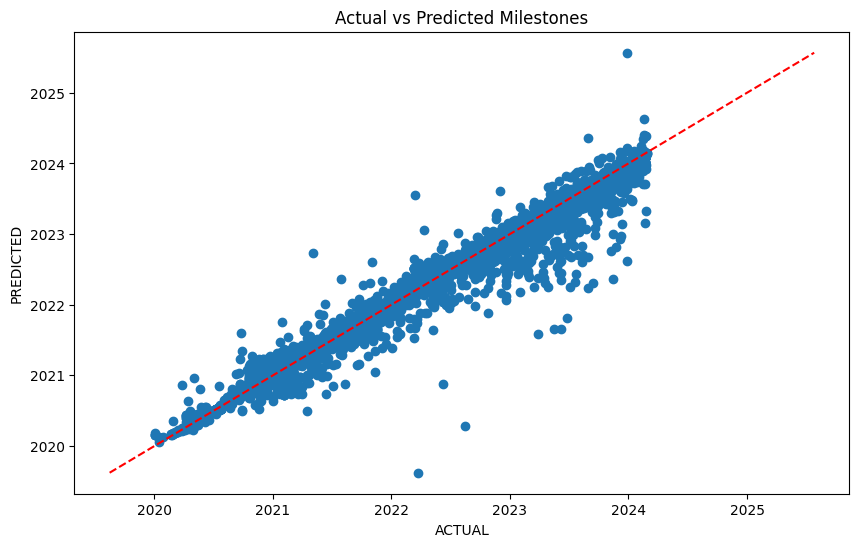

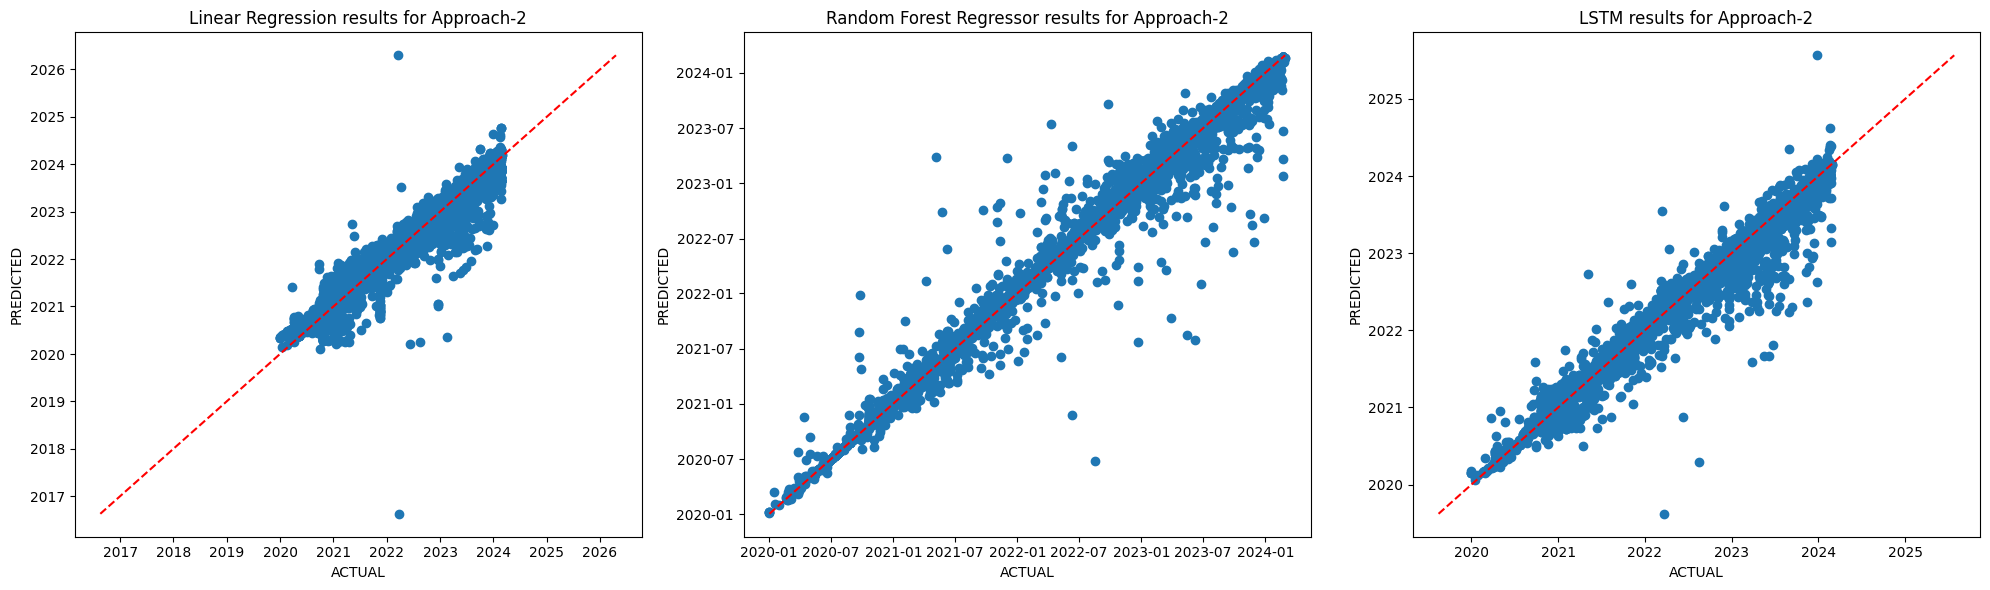

In [21]:
## Resultant plots for Approach-2

import matplotlib.pyplot as plt

# Assuming y_test, y_pred, y_pred_days, y_test_original, y_pred_original are defined

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Linear Regression results for Approach-1
axes[0].scatter(y_test_dates_a2, y_pred_dates_a2)
axes[0].set_title('Linear Regression results for Approach-2')
min_val = min(min(y_test_dates_a2), min(y_pred_dates_a2))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_dates_a2), max(y_pred_dates_a2))  # Get the maximum value for the diagonal line
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
axes[0].set_xlabel('ACTUAL')
axes[0].set_ylabel('PREDICTED')

# Plot 2: Random Forest Regressor results for Approach-1
axes[1].scatter(y_test_dates, y_pred_dates)
axes[1].set_title('Random Forest Regressor results for Approach-2')
min_val = min(min(y_test_dates), min(y_pred_dates))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_dates), max(y_pred_dates))  # Get the maximum value for the diagonal line
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
axes[1].set_xlabel('ACTUAL')
axes[1].set_ylabel('PREDICTED')

# Plot 3: LSTM results for Approach-1
axes[2].scatter(y_test_original_a2, y_pred_original_a2)
axes[2].set_title('LSTM results for Approach-2')
min_val = min(min(y_test_original_a2), min(y_pred_original_a2))  # Get the minimum value for the diagonal line
max_val = max(max(y_test_original_a2), max(y_pred_original_a2))  # Get the maximum value for the diagonal line
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction (y = x)')
axes[2].set_xlabel('ACTUAL')
axes[2].set_ylabel('PREDICTED')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


****PREDICTIONS FOR NEW DATA****

Previously we have considered only Milestone_Achieved = MS13 records so now for predicting let us consider Milestone_Achieved = MS12 so that "Tech_TTO_A" column will be empty

In [31]:
new_data = main_df

new_data['UPDATED_DATE'] = pd.to_datetime(dupdf['UPDATED_DATE'],format='mixed',dayfirst = True)
new_data = dupdf.sort_values(by=['Project_ID', 'UPDATED_DATE'], ascending=[True, False])

# Creating a new column to count non-null values across all columns
new_data['non_null_count'] = new_data.notnull().sum(axis=1)

# Sort by ProjectID and then by non_null_count to prioritize rows with the most filled data
new_data = new_data.sort_values(by=['Project_ID', 'non_null_count'], ascending=[True, False])

# Drop duplicates based on ProjectID, keeping the row with the most non-null values
new_data = new_data.drop_duplicates(subset=['Project_ID'], keep='first')

# Drop the helper column used for counting non-null values
new_data = new_data[(new_data['Milestone_Achieved'] == 'MS12') & (new_data['Project_Scope'] == 'In Scope')]

# Dropping all the columns that were discussed in the meeting
drop_columns_new = ['non_null_count','UPDATED_DATE','Created_Date','Upgrade_Project','Parent_Project','Milestone_Achieved','BT_Project','Project_Scope','Out_of_Scope_Reason','Out_of_Scope_Comments','Date_Removed_from_Scope','TM_Cell_ID_dup','SRN_Upgrade_Type','Created_Date','NTQ','Quality_Assurance','Upgrade_Project_Name']
new_data = new_data.drop(columns=drop_columns_new)

# Drop all the empty columns
new_data = new_data.dropna(axis=1, how='all')
new_data = new_data.reset_index(drop=True)

new_data_for_pred = new_data.copy()

new_data_for_pred.replace('01/01/1900', np.nan, inplace=True)
new_data_for_pred.replace('01/01/2999', np.nan, inplace=True)
new_data_for_pred.replace('2999-01-01', np.nan, inplace=True)
new_data_for_pred.replace('2999-12-31', np.nan, inplace=True)

cols_A_new = [col for col in new_data_for_pred.columns if col.endswith('_A')]
cols_F_new = [col for col in new_data_for_pred.columns if col.endswith('_F')]
common_cols_new = set([col[:-2] for col in cols_A]).intersection([col[:-2] for col in cols_F])
selected_columns_new = [col for col in new_data_for_pred.columns if col[:-2] in common_cols_new and (col.endswith('_A') or col.endswith('_F'))]

for col in selected_columns_new:
     new_data_for_pred[col] = pd.to_datetime(new_data_for_pred[col],format = 'mixed', dayfirst = True)


****SINCE RANDOM FOREST PERFORMED WELL IN APPROACH 2 LET US USE THAT MODEL****

Inputs required are ["Project_ID","Activation","BCQA","Build_Complete","Build_Start","Legal_Access","Legal_Access_Upgrade","Nomination_Issued","Tech_BIS"
,"WP1_Instruction_Issued","WP2_A_Acquisition","WP2_B_Design","WP2_C_Build","WP3_Instruction_Issued","WP4_Instruction_Issued"]

In [71]:
def new_data_preprocess(data,model):
    df = data
    df = df.drop(columns = 'Project_ID')
    df.replace('2999-01-01', np.nan, inplace=True)
    df.replace('01/01/2999', np.nan, inplace=True)
    milestones = ["Activation","BCQA","Build_Complete","Build_Start","Legal_Access","Legal_Access_Upgrade","Nomination_Issued","Tech_BIS","WP1_Instruction_Issued","WP2_A_Acquisition","WP2_B_Design","WP2_C_Build","WP3_Instruction_Issued","WP4_Instruction_Issued"]
    cols = []
    for milestone in milestones:
        cols.append(f'{milestone}_A')
        cols.append(f'{milestone}_F')
    df = df[cols]
    df = null_imputer(df) ## Null Handling
    for milestone in milestones:
        df[f'{milestone}_D'] = (df[f'{milestone}_A'] - df[f'{milestone}_F']).dt.days ## Actual - Forecast = Delay  

    features = []
    for milestone in milestones:
    # Add forecasted dates and delays for each milestone to the feature list
        features.append(f'{milestone}_F')
        features.append(f'{milestone}_D')
    df = df[features]
  
    # Convert forecasted dates to numeric values (timestamps)
    for feature in df.columns:
        if '_F' in feature:
            df[feature] = pd.to_datetime(df[feature]).apply(lambda x: x.timestamp())
    model = eval(model)
    predictions = model.predict(df)
    predictions = pd.to_datetime(predictions, unit='s').date
    data['Tech_TTO_Predictions'] = predictions
    return data[['Project_ID','Tech_TTO_Predictions']]
    #return predictions


****NOTE: BEFORE RUNNING THIS METHOD, PLEASE RUN THE RANDOM FOREST REGRESSOR MODEL CELL****

In [74]:
dats = new_data_preprocess(new_data_for_pred,'rf_model')
dats

,Project_ID,Tech_TTO_Predictions
0,P-167292,2023-11-21
1,P-171956,2024-01-18
2,P-172040,2024-01-25
3,P-172061,2024-01-18
4,P-172068,2024-01-18
...,...,...
541,P-275282,2024-02-14
542,P-275315,2024-02-14
543,P-275409,2023-10-31
544,P-275410,2023-10-31
